In [175]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import string

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict, fix

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [100]:
column_names=['target','id','date','flag','user','text']
df=pd.read_csv('../data/raw data/train_data.csv',encoding='ISO-8859-1')
df.columns=column_names

In [74]:
df.head()

,target,id,date,flag,user,text
0,0,1557995356,Sun Apr 19 06:52:38 PDT 2009,NO_QUERY,dove1996,really bored doing nothing!!!!!! don't wanna ...
1,4,1687098117,Sun May 03 07:45:34 PDT 2009,NO_QUERY,SweetOne76,Running on 4 hrs of sleep.. Whoo hoo! Lol 4pm ...
2,0,2051623322,Fri Jun 05 22:25:48 PDT 2009,NO_QUERY,mzjaisuperstarr,thinks that reality is finally setting in now....
3,4,1694664325,Mon May 04 03:37:36 PDT 2009,NO_QUERY,Hend__X,Exploring Twitter's world! me 2
4,0,2264413988,Sun Jun 21 03:47:49 PDT 2009,NO_QUERY,akaSylvia,Too hungover to make it through the day


In [75]:
#Starting now, we'll exclusively utilize the text and target columns, as none of the others demonstrated 
#significant impact during exploratory data analysis.

df=df[['target','text']]
df.head()

,target,text
0,0,really bored doing nothing!!!!!! don't wanna ...
1,4,Running on 4 hrs of sleep.. Whoo hoo! Lol 4pm ...
2,0,thinks that reality is finally setting in now....
3,4,Exploring Twitter's world! me 2
4,0,Too hungover to make it through the day


In [76]:
tweets=df.copy()

# Features engineering

## Loooking for outliers

In [77]:
# Twitter originally limited tweets to 140 characters when it was launched in 2006.
# This constraint was based on the 160-character limit of SMS messages, with 20 characters reserved for the username.
# In November 2017, Twitter doubled the character limit to 280 characters, allowing users more space for expression.
# Our data is from 2009 so we are looking for outliers as tweets are limited to 140 characters.

tweets['char_count'] = tweets['text'].apply(lambda x: len(str(x)))
tweets['text'] = tweets['text'].replace({'&amp;': '&', '&quot;': '"', "ï¿½" : '�',"&lt;":"<","&gt;":">",'quot':"'",'amp':'&'}, regex=True)

# Records with more than 140 characters are shown below, as we can see outliers may be caused by encoding issues or text processing errors.
tweets.loc[tweets['char_count']>140]['text'].info()

# So we decided to drop these records
tweets=tweets.loc[tweets['char_count']<=140]
tweets=tweets.drop(columns=['char_count'])

<class 'pandas.core.series.Series'>
Int64Index: 5541 entries, 66 to 513552
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
5541 non-null   object
dtypes: object(1)
memory usage: 86.6+ KB


In [78]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508260 entries, 0 to 513800
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  508260 non-null  int64 
 1   text    508260 non-null  object
dtypes: int64(1), object(1)
memory usage: 11.6+ MB


### Polarity and sentiment before cleaning text

In [55]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({'polarity': blob.sentiment.polarity})

sentiment_data = tweets['text'].apply(analyze_sentiment)

tweets = pd.concat([tweets, sentiment_data], axis=1)

## The text cleaning process involves several steps to prepare the text data for analysis:

1. **Remove @mentions:** Eliminate any mentions of Twitter usernames.
2. **Remove # symbol:** Get rid of '#' symbols typically used for hashtags.
3. **Remove RT (retweet):** Discard any "RT" markers indicating retweets.
4. **Remove hyperlinks:** Delete any hyperlinks starting with "http" or "https".
5. **Remove colons:** Eliminate any colons from the text.
6. **Remove double dashes:** Discard any occurrences of double dashes.
7. **Remove single quotes:** Eliminate any single quotes from the text.
8. **Convert to lowercase:** Convert all text to lowercase to ensure consistency.
9. **Strip whitespace:** Remove any leading or trailing whitespace from the text.
10. **Expand contractions:** Replace contractions with their full forms for text standardization. This ensures consistency in the text by converting contractions like "can't" to "cannot".

These steps ensure that the text data is cleaned and standardized, making it ready for further analysis or processing. After cleaning, the text is often more suitable for natural language processing tasks.

In [57]:
my_contractions={
            "a'ight": "alright",
            "ain't": "am not",
            "amn't": "am not",
            "n": "and",
            "arencha": "are not you",
            "aren't": "are not",
            "'bout": "about",
            "can't": "can not",
            "cant": "can not",
            "cap'n": "captain",
            "'cause": "because",
            "cuz": "because",
            "'cept": "except",
            "c'mon": "come on",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "cuppa": "cup of",
            "daren't": "dare not",
            "daresn't": "dare not",
            "dasn't": "dare not",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "dunno": "do not know",
            "d'ye": "do you",
            "d'ya": "do you",
            "e'en": "even",
            "e'er": "ever",
            "'em": "them",
            "everybody's": "everybody has",
            "everyone's": "everyone is",
            "everything's": "everything is",
            "finna": "fixing to",
            "fo'c'sle": "forecastle",
            "'gainst": "against",
            "g'day": "good day",
            "gimme": "give me",
            "giv'n": "given",
            "gi'z": "give us",
            "gonna": "going to",
            "gon't": "go not",
            "gotta": "got to",
            "hadn't": "had not",
            "had've": "had have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'll": "he will",
            "helluva": "hell of a",
            "yes'nt": "yes not",
            "he's": "he is",
            "here's": "here is",
            "how'd": "how would",
            "howdy": "how do you do",
            "how'll": "how will",
            "how're": "how are",
            "how's": "how is",
            "I'd": "I would",
            "I'd've": "I would have",
            "I'd'nt": "I would not",
            "I'd'nt've": "I would not have",
            "If'n": "If and when",
            "I'll": "I will",
            "I'm": "I am",
            "I'm 'onna": "I am going to",
            "Imma": "I am about to",
            "I'm'o": "I am going to",
            "I'm'na": "I am going to",
            "Ion": "I do not",
            "I've": "I have",
            "isn't": "is not",
            "it'd": "it would",
            "it'll": "it will",
            "it's": "it is",
            "its": "it is",
            "Idunno": "I do not know",
            "kinda": "kind of",
            "lemme": "let me",
            "let's": "let us",
            "loven't": "love not",
            "ma'am": "madam",
            "mayn't": "may not",
            "may've": "may have",
            "methinks": "I think",
            "mightn't": "might not",
            "might've": "might have",
            "mine's": "mine is",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "must've": "must have",
            "'neath": "beneath",
            "needn't": "need not",
            "nal": "and all",
            "ne'er": "never",
            "o'clock": "of the clock",
            "o'er": "over",
            "ol'": "old",
            "ought've": "ought have",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "'round": "around",
            "shalln't": "shall not",
            "shan'": "shall not",
            "shan't": "shall not",
            "she'd": "she would",
            "she'll": "she will",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "somebody's": "somebody has",
            "someone's": "someone has",
            "something's": "something is",
            "so's": "so is",
            "so've": "so have",
            "that'll": "that will",
            "that're": "that are",
            "that's": "that is",
            "there'll": "there will",
            "there're": "there are",
            "there's": "there is",
            "these're": "these are",
            "these've": "these have",
            "these've": "these have",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they're": "they are ",
            "they've": "they have",
            "this's": "this is",
            "those're": "those are",
            "those've": "those have",
            "'thout": "without",
            "'til": "until",
            "til": "until"}

contractions_dict.update(my_contractions)

punctuation_chars = ''.join([c for c in string.punctuation if c != '_'])

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.cleantxt)

    def cleantxt(self, text):
        text = fix(text)

        pattern = r'|'.join([
            r'@[\w_]+',                                          # removed @mentions
            r'#',                                                # removed # symbol
            r'RT[\s]+',                                          # removed RT (retweet)
            r'https?:\/\/\S+',                                   # removed the hyperlink
            r'http|\'',                                          # removed http and '
            r'[' + re.escape(punctuation_chars + '_') + r']',    # removed all punctuations
            r'\d+'                                               # removed numbers
        ])

        text = re.sub(pattern, '', text)
        text = ' '.join(word for word in text.split() if len(word) > 2)
        text = text.lower().strip()
        return text

## Tokenization
Tokenization is the process of breaking down text into smaller units called tokens. Tokens can represent individual words, numbers, punctuation marks, or other elements of text, depending on the context and application. Tokenization is a fundamental step in text processing and natural language processing (NLP).

In [16]:
class WordTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, separator=' '):
        self.separator = separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.tokenize)

    def tokenize(self, text):
        return text.split(self.separator)

In [17]:
class TokensToSentences(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.tokens_to_sentence)
    
    def tokens_to_sentence(self, tokens):
        cleaned_tokens = [token.strip() for token in tokens]
        return ' '.join(cleaned_tokens)

## Lemmatization and Stopword Removal

The text cleaning process involves the following steps:

1. **Stopword Removal**: Stopwords, which are commonly occurring words in a language and often do not carry significant meaning (e.g., "the", "a", "in"), are removed from the text. This step helps in focusing on the most important words in the text, which are likely to carry more semantic meaning.

2. **Lemmatization**: The text is first lemmatized, which involves reducing words to their base or dictionary form. This helps in standardizing words and reducing inflectional forms to a common base, thereby simplifying the analysis.

### Stopword Removal

Stopwords are common words in a language that are often filtered out because they do not carry significant meaning. Examples of stopwords in English include "the", "a", "an", "in", "on", etc. By removing stopwords, the text becomes more focused on the content words that are likely to carry more semantic meaning.

### Lemmatization

Lemmatization involves reducing words to their base form, or lemma. For example:
- "running" -> "run"
- "cars" -> "car"
- "better" -> "good"

After applying both lemmatization and stopwords removal, the text is cleaned and ready for further analysis.


In [18]:
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.pos_mapping = {'N': 'n', 'V': 'v', 'J': 'a', 'R': 'r'}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.lemmatize_tokens)

    def lemmatize_tokens(self, tokens):
        lemmatized_tokens = []
        for tok, tag in pos_tag(tokens):
            pos = self.pos_mapping.get(tag[0], 'n')
            lemma = self.lemmatizer.lemmatize(tok, pos=pos)
            lemmatized_tokens.append(lemma)
        return lemmatized_tokens

In [19]:
class StopwordsRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        words_to_remove = ["not", "against", "most", "only", "same", "very", "down", "nor","such"]
        self.stop_words.update(["im", "i", "u"])
        self.stop_words=[word for word in self.stop_words if word not in words_to_remove]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(lambda tokens: [token for token in tokens if token not in self.stop_words])

## Not vs target

In [20]:
def contains_not_numeric(text):
    return int('not' in text)

## Processing pipeline

In [58]:
text_processing = Pipeline([
    ('cleaner', TextCleaner()),                       # Text cleaning
    ('tokenizer', WordTokenizer()),                   # Tokenization
    ('stopwords_remover', StopwordsRemover()),        # Removing stopwords
    ('lemmatizer', Lemmatizer()),                     # Lemmatization
    ('tokens_to_sentences', TokensToSentences())      # Tokens to sentences
])
processed_data = text_processing.fit_transform(tweets['text'])

In [59]:
processed_df = pd.DataFrame({
    'target': tweets['target'],
    'text': processed_data,
    'polarity': tweets['polarity'],
    'contains_not': processed_data.apply(contains_not_numeric)
})

In [177]:
processed_df['text'].tolist()[:20]

['really bore nothing not want tomoz lazy nothing look forward',
 'run hrs sleep whoo hoo lol come around head home guess nap course',
 'think reality finally set nowin day half heart afganman miss baby month',
 'explore twitter world',
 'hungover make day',
 'apparently official word archive sad',
 'good good afternoon pick min agoi think go shop',
 'suddenly miss christmas much',
 'sorry kitty',
 'satellite still break',
 'life cannot get bad',
 'time nerd',
 'need see boy take away pain funny rely much',
 'use abused huh feel like sometimes especially client ignore invoice',
 'hellow sir exactly fine work terrible cross bewitch hour every since day since last month miss home',
 'yea hear large mammal not great heat lol',
 'not say bye',
 'wonder source food counsel free smoke friend',
 'lot prev classmate transfer school ill miss yall',
 'bacon fail gulb lack chef']

In [130]:
# Find records in the `processed_df` dataframe that contain empty values in the 'text' column 
# (which may occur after text processing), in order to delete these records from the dataframe.
processed_df[processed_df['text'].isna()]

,target,text,polarity,contains_not


In [131]:
nan_indexes = processed_df[processed_df['text'].isna()].index
tweets.iloc[nan_indexes]

,target,text


In [132]:
# We can observe that after text cleaning, there are records that do not contain any text.
# We can notice that these are mainly tweets with mentions or links, so we decide to drop these records since
# they do not provide new information to the model and their quantity is relatively small.
processed_df = processed_df.dropna()

In [178]:
all_words = ' '.join(processed_df['text'])
words_list = all_words.split()
unique_words_count = len(set(words_list))

print("Unique words:", unique_words_count)

Unique words: 167096


In [134]:
processed_df['target'] = processed_df['target'].replace(4, 1)
processed_df.head()

,target,text,polarity,contains_not
0,0,really bore nothing not want tomoz lazy nothin...,-0.656250,1
1,1,run hrs sleep whoo hoo lol come around head ho...,1.000000,0
2,0,think reality finally set nowin day half heart...,-0.153472,0
3,1,explore twitter world,0.000000,0
4,0,hungover make day,0.000000,0


In [135]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505612 entries, 0 to 505611
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   target        505612 non-null  int64  
 1   text          505612 non-null  object 
 2   polarity      505612 non-null  float64
 3   contains_not  505612 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 15.4+ MB


In [128]:
processed_df.to_csv('../data/processed data/processed_train_data.csv', index=False)
#same with test and validation dataset
#processed_df.to_csv('../data/processed data/processed_val_data.csv', index=False)
#processed_df.to_csv(./data/processed data/processed_test_data.csv, index=False)

## Getting processed datasets for features engineering

To train and evaluate machine learning models effectively, the dataset is split into three subsets:

1. **Training Data**: Used to train the model, this subset contains features (input variables) and their corresponding labels (output variable).

2. **Validation Data**: Reserved for evaluating the model's performance during training. It allows adjusting model parameters to optimize performance without overfitting.

3. **Test Data**: Used for final evaluation of the trained model's performance. It serves to assess the model's ability to generalize to unseen data.

Both of them we have already processed so now we are using processed datasets.


In [117]:
processed_train_data=pd.read_csv('../data/processed data/processed_train_data.csv', encoding='ISO-8859-1')
#our test data is from validation data set, validation team has independent test set
processed_test_data=pd.read_csv('../data/processed data/processed_val_data.csv', encoding='ISO-8859-1')

In [118]:
X_train=processed_train_data.drop('target', axis=1)
y_train=processed_train_data['target']
X_test=processed_test_data.drop('target',axis=1)
y_test=processed_test_data['target']

In [119]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((505612, 3), (216619, 3), (505612,), (216619,))

In [120]:
X_train.head(), y_train.head()

(                                                text  polarity  contains_not
 0  really bore nothing not want tomoz lazy nothin... -0.656250             1
 1  run hrs sleep whoo hoo lol come around head ho...  1.000000             0
 2  think reality finally set nowin day half heart... -0.153472             0
 3                              explore twitter world  0.000000             0
 4                                  hungover make day  0.000000             0,
 0    0
 1    1
 2    0
 3    1
 4    0
 Name: target, dtype: int64)

## Bag of words
The Bag of Words (BoW) model is a technique used in natural language processing (NLP) and machine learning for representing text data. In BoW, each document is represented as an unordered collection or "bag" of words, disregarding grammar, syntax, and word order.

The process of creating a Bag of Words typically involves the following steps:

1. **Tokenization**: The documents are split into individual words or tokens.
2. **Building a Vocabulary**: A vocabulary, or dictionary, is constructed containing all unique words found in the corpus of documents. Each word is assigned a unique index.
3. **Creating Feature Vectors**: For each document, a feature vector is created representing the frequency or occurrence of each word from the vocabulary in that document.


In [121]:
count_vectorizer = CountVectorizer(max_df=0.8)
count_train = count_vectorizer.fit_transform(X_train['text'])
count_test = count_vectorizer.transform(X_test['text'])
print(count_vectorizer.get_feature_names_out()[:10])

['aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaa'
 'aaaaaaaaaa' 'aaaaaaaaaaa' 'aaaaaaaaaaaa']


### Basic Models for BoW

In [136]:
l_SVC_bow=LinearSVC(class_weight='balanced')
l_SVC_bow.fit(count_train,y_train)

c:\Users\abc\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced')

In [137]:
y_pred_test = l_SVC_bow.predict(count_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.905414,0.790687,0.844170,165374.000000
1,0.520568,0.733437,0.608935,51245.000000
accuracy,0.777143,0.777143,0.777143,0.777143
macro avg,0.712991,0.762062,0.726553,216619.000000
weighted avg,0.814372,0.777143,0.788521,216619.000000


In [138]:
print(metrics.roc_auc_score(y_test,y_pred_test))

0.7620619867628933


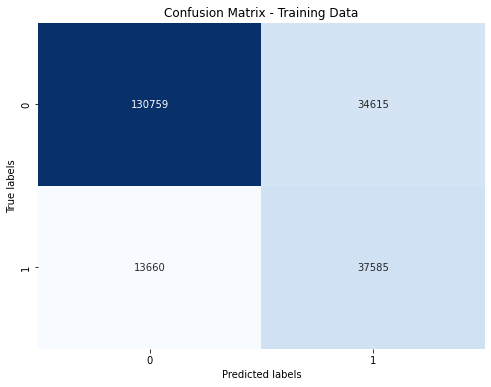

In [139]:
y_pred_test = l_SVC_bow.predict(count_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

In [140]:
lr_bow=LogisticRegression(solver='sag')
lr_bow.fit(count_train,y_train)

c:\Users\abc\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='sag')

In [141]:
y_pred_test = lr_bow.predict(count_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.853667,0.943492,0.896335,165374.000000
1,0.723880,0.478076,0.575844,51245.000000
accuracy,0.833389,0.833389,0.833389,0.833389
macro avg,0.788774,0.710784,0.736089,216619.000000
weighted avg,0.822964,0.833389,0.820517,216619.000000


In [142]:
print(metrics.roc_auc_score(y_test,y_pred_test))

0.7107838158195496


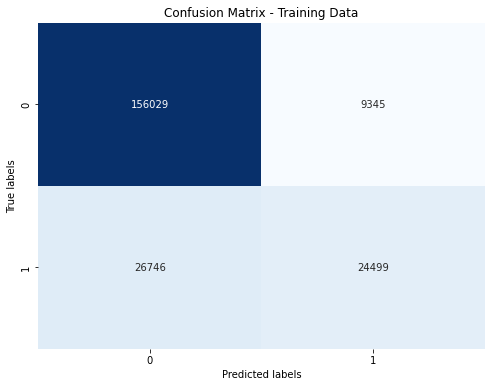

In [143]:
y_pred_test = lr_bow.predict(count_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

In [144]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train,y_train)

MultinomialNB()

In [145]:
y_pred_test = nb_classifier.predict(count_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.830429,0.961953,0.891365,165374.000000
1,0.748852,0.366104,0.491782,51245.000000
accuracy,0.820994,0.820994,0.820994,0.820994
macro avg,0.789641,0.664028,0.691574,216619.000000
weighted avg,0.811131,0.820994,0.796837,216619.000000


In [146]:
print(metrics.roc_auc_score(y_test,y_pred_test))

0.6640284584460217


## TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF is a statistical measure used to evaluate the importance of a term in a document relative to a collection of documents. It is commonly used in natural language processing and information retrieval to extract relevant information from text data.

### Term Frequency (TF)

Term Frequency measures the frequency of a term (word) in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in the document. TF is used to represent how often a term occurs within a document.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

### Inverse Document Frequency (IDF)

Inverse Document Frequency measures the importance of a term across a collection of documents. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term, then the result is inverted. IDF is used to represent how unique or rare a term is across the entire document collection.

IDF(t) = log_e(Total number of documents / Number of documents containing term t)

### TF-IDF Calculation

TF-IDF is computed as the product of TF and IDF:

TF-IDF(t, d) = TF(t) * IDF(t)

Where:
- TF-IDF(t, d) is the TF-IDF score for term t in document d.
- TF(t) is the Term Frequency of term t in document d.
- IDF(t) is the Inverse Document Frequency of term t.

### Applications of TF-IDF

- Information retrieval: TF-IDF is used to rank the relevance of documents to a query in search engines.
- Text mining: TF-IDF helps in extracting important features from text data for tasks such as classification, clustering, and sentiment analysis.
- Keyword extraction: TF-IDF identifies significant keywords in documents for indexing and summarization.

In [147]:
# Performing TF-IDF Vectorization with Both Unigrams and Bigrams.
# Here we're utilizing TF-IDF vectorization to convert our text data into numerical features,
# aiming to capture both single words (unigrams) and sequences of two words (bigrams).
# By specifying ngram_range=(1, 2), we ensure that our TF-IDF representation includes both
# individual words and meaningful pairs of adjacent words.

# Including bigrams enables us to detect not only individual words but also collocations,
# such as negations or emphatic expressions, which can significantly impact sentiment analysis results.

tfidf = TfidfVectorizer(norm='l2')
tfidf_vector=tfidf.fit_transform(X_train['text'])

tfidf_biagrams = TfidfVectorizer(ngram_range=(1, 2),norm='l2')
tfidf_biagrams_vector=tfidf_biagrams.fit_transform(X_train['text'])

In [148]:
tfidf_vector_test=tfidf.transform(X_test['text'])
tfidf_biagrams_vector_test=tfidf_biagrams.transform(X_test['text'])

In [149]:
print(tfidf_vector)

  (0, 50931)	0.31352684174137296
  (0, 82647)	0.23266635722882933
  (0, 79371)	0.3622244908924406
  (0, 144657)	0.4650906585220032
  (0, 155327)	0.19125824123932605
  (0, 99000)	0.12743938740434393
  (0, 99090)	0.5700679234159668
  (0, 17910)	0.276934396103799
  (0, 115796)	0.21344969879975353
  (1, 30657)	0.2936496196756181
  (1, 95247)	0.2961765890801822
  (1, 58527)	0.24278231045931017
  (1, 64368)	0.19335152733216548
  (1, 61352)	0.23712170188258969
  (1, 7973)	0.26071005898521393
  (1, 28385)	0.19264203330271082
  (1, 82126)	0.19063176577744953
  (1, 64887)	0.3594132389115824
  (1, 158279)	0.41324509555658345
  (1, 128743)	0.2017864126421686
  (1, 65966)	0.3573677300382783
  (1, 120471)	0.2523778317665004
  (2, 91729)	0.233639827137946
  (2, 10862)	0.2215796981934975
  (2, 90271)	0.1507237524489683
  :	:
  (505609, 52601)	0.26382387436537597
  (505609, 81346)	0.2432440228958278
  (505609, 160224)	0.14863428697180106
  (505609, 55845)	0.1416464919746426
  (505610, 161988)	0.5444313

### Basic models

### Linear SVC for TF-IDF

In [150]:
l_SVC=LinearSVC()
l_SVC.fit(tfidf_vector,y_train)

LinearSVC()

In [151]:
y_pred_test = l_SVC.predict(tfidf_vector_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.856212,0.934065,0.893445,165374.000000
1,0.698851,0.493785,0.578688,51245.000000
accuracy,0.829909,0.829909,0.829909,0.829909
macro avg,0.777531,0.713925,0.736067,216619.000000
weighted avg,0.818985,0.829909,0.818984,216619.000000


In [152]:
print(metrics.roc_auc_score(y_test,y_pred_test))

0.7139246822828538


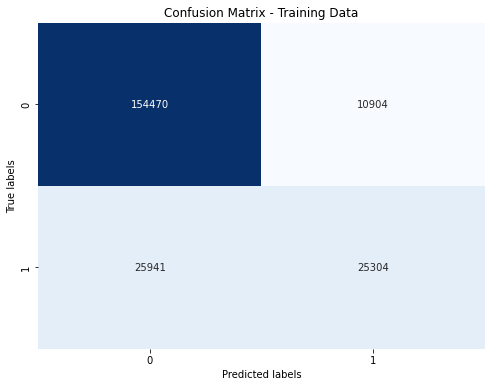

In [153]:
y_pred_test = l_SVC.predict(tfidf_vector_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

### Linear SVC for TF-IDF using biagrams

In [154]:
l_SVC_biagrams=LinearSVC()
l_SVC_biagrams.fit(tfidf_biagrams_vector,y_train)

LinearSVC()

In [155]:
y_pred_test = l_SVC_biagrams.predict(tfidf_biagrams_vector_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.868028,0.929808,0.897856,165374.000000
1,0.705940,0.543799,0.614352,51245.000000
accuracy,0.838491,0.838491,0.838491,0.838491
macro avg,0.786984,0.736803,0.756104,216619.000000
weighted avg,0.829684,0.838491,0.830789,216619.000000


In [156]:
print(metrics.roc_auc_score(y_test,y_pred_test))

0.7368034913563725


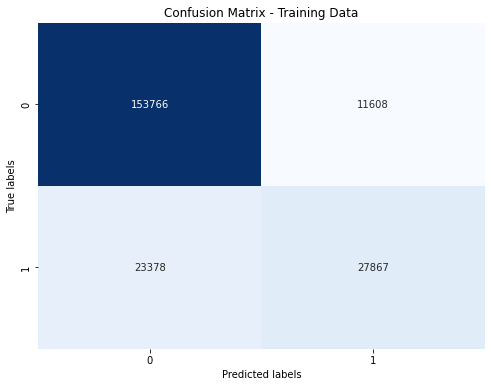

In [157]:
y_pred_test = l_SVC_biagrams.predict(tfidf_biagrams_vector_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

### Logistic regression

In [158]:
lr=LogisticRegression(solver='sag')
lr.fit(tfidf_vector,y_train)

LogisticRegression(solver='sag')

In [159]:
y_pred_test = lr.predict(tfidf_vector_test)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.855416,0.946382,0.898603,165374.000000
1,0.736564,0.483794,0.584001,51245.000000
accuracy,0.836949,0.836949,0.836949,0.836949
macro avg,0.795990,0.715088,0.741302,216619.000000
weighted avg,0.827300,0.836949,0.824178,216619.000000


In [160]:
print(metrics.roc_auc_score(y_test,y_pred_test))

0.7150878403550686


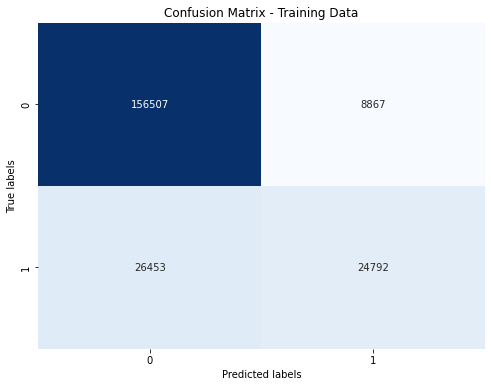

In [161]:
y_pred_test = lr.predict(tfidf_vector_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

In [103]:
negative_tweets = X_train[y_train == 0]
positive_tweets = X_train[y_train == 1]

tfidf_negative = TfidfVectorizer()
tfidf_vector_negative = tfidf_negative.fit_transform(negative_tweets)

tfidf_positive = TfidfVectorizer()
tfidf_vector_positive = tfidf_positive.fit_transform(positive_tweets)

In [110]:
top_negative_indices = tfidf_vector_negative.max(axis=0).toarray().flatten().argsort()[-100:][::-1]
top_positive_indices = tfidf_vector_positive.max(axis=0).toarray().flatten().argsort()[-100:][::-1]

negative_words = tfidf_negative.get_feature_names_out()
positive_words = tfidf_positive.get_feature_names_out()

top_negative_words = [negative_words[i] for i in top_negative_indices]
top_positive_words = [positive_words[i] for i in top_positive_indices]

print("Most popular words in negative tweets:")
print(top_negative_words)

print("\nMost popular words in positive tweets:")
print(top_positive_words)


Most popular words in negative tweets:
['awhh', '_hudson', 'whewwwwwww', 'together', 'southworst', 'whhhhhhhhyyyyy', 'sowee', 'whhyy', 'fuckkk', '_hope', 'fuckofffuckofffuckoffffff', 'sowhat', 'apartmentaloneagain', 'sowry', 'boring', '_hoffman', 'full', 'fuck', 'fucccckkkkkkkkkk', 'sowwy', 'wheres', 'borrrrrrredddddd', 'borrrrrreeeeeeeeeeeed', 'borrrreed', 'narm', 'soup', '_ice_queen_', 'sourceforge', 'soursally', 'borreeeddd', 'borreed', 'frozen', 'frustrate', 'fsckvpscom', 'fsdfhjdsfdsjkhjkds', 'naman', 'apathetic', 'fun', 'whoever', 'spa', 'myheartisbroken', '_headedness', 'spammer', 'boredreallybored', 'fuuuuck', 'fuuuuuck', 'fuuuuuuuuuuuuuuuuuuuuuuuuck', 'boredom', 'borednothing', 'spanish', 'mutilate', 'mustsleepnow', 'fyl', 'boredness', 'mustace', 'spacey', 'boreed', 'mzfreeproductcodenotavailableincountry_explination', 'boreedd', 'boreeeeeeeeeeed', 'fund', 'whine', 'boreeeeeeeeed', 'funeral', 'boreeeeeeed', 'boreeeeeeddddd', 'myt', 'funk', 'boreeeeeedd', 'boreeeeed', 'funny', 

In [113]:
def check_word_presence(tweet, words):
    for word in words:
        if word in tweet:
            return 1
    return 0

negative_tweets_presence = pd.DataFrame()
for word in top_negative_words:
    negative_tweets_presence[word] = X_train.apply(lambda tweet: check_word_presence(tweet, [word]))

positive_tweets_presence = pd.DataFrame()
for word in top_positive_words:
    positive_tweets_presence[word] = X_train.apply(lambda tweet: check_word_presence(tweet, [word]))

X_train_with_words = pd.concat([X_train, negative_tweets_presence, positive_tweets_presence], axis=1)

correlation_negative = X_train_with_words[top_negative_words].corrwith(y_train).sort_values(ascending=False)
correlation_positive = X_train_with_words[top_positive_words].corrwith(y_train).sort_values(ascending=False)

print("Correlation between presence of top negative words and target:")
print(correlation_negative)

print("\nCorrelation between presence of top positive words and target:")
print(correlation_positive)


Correlation between presence of top negative words and target:
fun          0.037019
funny        0.027244
sound        0.022963
spa          0.006976
together     0.004792
               ...   
frustrate   -0.012278
anything    -0.012676
boring      -0.016322
need        -0.028910
fuck        -0.029019
Length: 100, dtype: float64

Correlation between presence of top positive words and target:
wonderful    0.038360
birthday     0.037552
best         0.034293
woo          0.031140
hope         0.021461
               ...   
hour        -0.021511
hit         -0.022383
home        -0.031140
ho          -0.033980
wont        -0.042815
Length: 100, dtype: float64


## Word Embedding

Word Embedding is a technique of representing words as real-valued vectors in a multi-dimensional space, where similar words are represented by similar vectors. This technique enables the semantic representation of words, meaning that words with similar meanings will have similar vector representations. Word Embedding is widely used in natural language processing and machine learning, particularly in text analysis.

### Word2Vec

Word2Vec is a popular algorithm for generating word embeddings. It is based on the distributional hypothesis, which suggests that words appearing in similar contexts tend to have similar meanings. Word2Vec uses a neural network model to learn word embeddings by predicting the probability of neighboring words given a target word or vice versa.

#### Mathematics behind Word2Vec:

Word2Vec consists of two main models: Continuous Bag of Words (CBOW) and Skip-gram.

**1. Continuous Bag of Words (CBOW):**
   - Given a target word, CBOW predicts the probability distribution of context words surrounding the target word.
   - Let's denote:
     - \( V \) as the size of the vocabulary.
     - \( N \) as the dimensionality of the word vectors.
     - \( w_{t} \) as the target word.
     - \( c_{t} \) as the context window centered around the target word.
     - \( W_{input} \) as the input word vectors matrix.
     - \( W_{output} \) as the output word vectors matrix.
     - \( \hat{v} \) as the output of the softmax function.

   - The objective of CBOW is to maximize the average log probability:
     \[ \frac{1}{T} \sum_{t=1}^{T} \log P(w_{t} | c_{t}) \]

**2. Skip-gram:**
   - Given a target word, Skip-gram predicts the probability distribution of context words within a fixed context window around the target word.
   - The objective of Skip-gram is to maximize the average log probability of predicting context words given the target word.

Both CBOW and Skip-gram models are trained using the backpropagation algorithm to adjust the word vectors in order to minimize the prediction error.

These word vectors, learned by Word2Vec, capture semantic relationships between words and can be used for various natural language processing tasks such as sentiment analysis, document classification, and machine translation.



In [162]:
tokenized_sentences = [word_tokenize(text) for text in X_train['text']]

model = Word2Vec(tokenized_sentences, vector_size=100, window=7, min_count=5, sg=1)
#model.save("word2vec.model")

In [163]:
def text_to_vector(text, embedding_model, embedding_dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in embedding_model.wv:
            vectors.append(embedding_model.wv[word])
    if not vectors:
        return np.zeros(embedding_dim)
    avg_vector = np.mean(vectors, axis=0)
    return avg_vector

embedding_dim = 10

word2vec_vector = X_train['text'].apply(lambda x: text_to_vector(x, model, embedding_dim))
word2vec_vector_test = X_test['text'].apply(lambda x: text_to_vector(x, model, embedding_dim))

print(word2vec_vector)

0         [0.021756165, -0.06688638, -0.10579471, 0.0242...
1         [-0.18875071, -0.006752626, -0.09327113, 0.036...
2         [-0.16246939, 0.059748642, 0.14143112, 0.17252...
3         [-0.41538456, -0.05620629, 0.09774202, -0.0211...
4         [-0.26604816, 0.190452, 0.057154793, 0.0015439...
                                ...                        
505607    [-0.09767956, -0.11111055, 0.070428714, 0.0385...
505608    [-0.2661906, -0.043495297, 0.104758516, -0.017...
505609    [-0.17602482, -0.06852984, 0.046716165, -0.008...
505610    [-0.038899895, 0.24466059, 0.1215664, -0.00942...
505611    [-0.31907055, 0.19796632, 0.05641396, 0.051065...
Name: text, Length: 505612, dtype: object


In [164]:
similar_words = model.wv.most_similar("bad", topn=10)
print(similar_words)

[('horrible', 0.7633162140846252), ('terrible', 0.739584743976593), ('sucky', 0.7324002385139465), ('siick', 0.692584216594696), ('worst', 0.6913172006607056), ('dismiss', 0.6902362704277039), ('baad', 0.6876357197761536), ('awful', 0.6839306354522705), ('reeeally', 0.6829268336296082), ('pissy', 0.6805790662765503)]


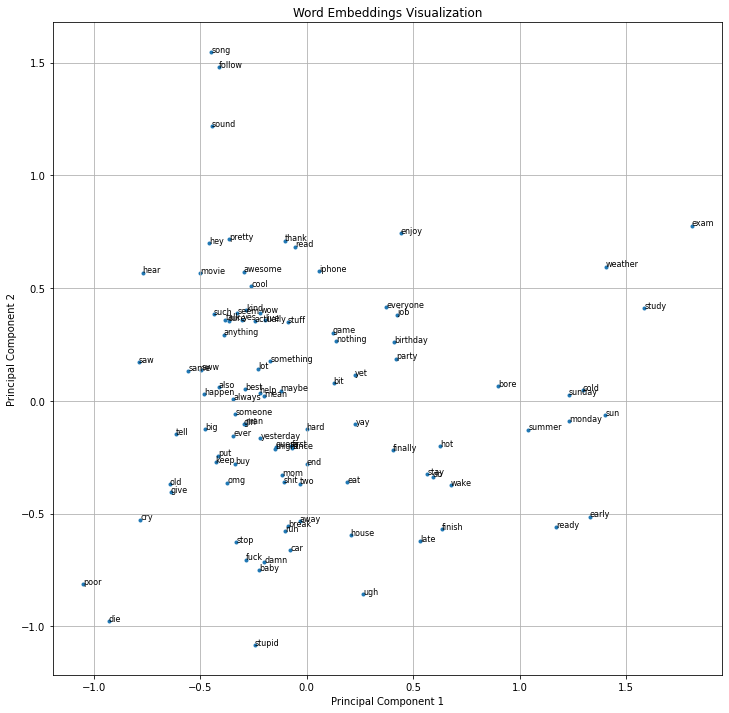

In [165]:
words = list(model.wv.index_to_key)[100:200]
word_vectors = model.wv[words]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(word_vectors)

plt.figure(figsize=(12, 12))
plt.scatter(principal_components[:, 0], principal_components[:, 1], marker='.')
for i, word in enumerate(words):
    plt.annotate(word, xy=(principal_components[i, 0], principal_components[i, 1]), fontsize=8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Word Embeddings Visualization')
plt.grid(True)

plt.show()

In [166]:
max_length = 100 

def pad_or_truncate_sequences(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = np.pad(seq, (0, max_length - len(seq)), mode='constant')
        else:
            padded_seq = seq[:max_length]
        padded_sequences.append(padded_seq)
    return np.array(padded_sequences)

X_train_w2v_pad = pad_or_truncate_sequences(word2vec_vector, max_length)
X_test_w2v_pad = pad_or_truncate_sequences(word2vec_vector_test, max_length)

In [167]:
l_SVC_w2v = LinearSVC()
l_SVC_w2v.fit(X_train_w2v_pad, y_train)

LinearSVC()

In [168]:
y_pred_test = l_SVC_w2v.predict(X_test_w2v_pad)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.823714,0.965635,0.889047,165374.000000
1,0.750220,0.333086,0.461343,51245.000000
accuracy,0.815995,0.815995,0.815995,0.815995
macro avg,0.786967,0.649361,0.675195,216619.000000
weighted avg,0.806328,0.815995,0.787866,216619.000000


In [169]:
print(metrics.roc_auc_score(y_pred_test,y_test))

0.7869669783573985


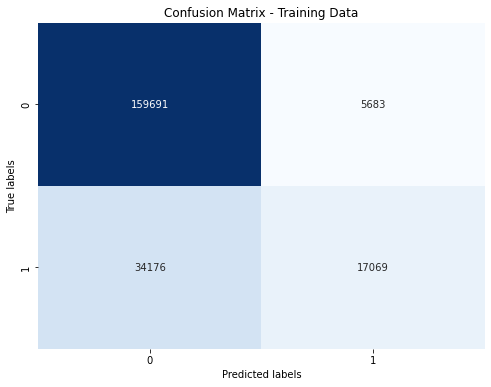

In [170]:
y_pred_test = l_SVC_w2v.predict(X_test_w2v_pad)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

In [171]:
lr_w2v=LogisticRegression(solver='sag')
lr_w2v.fit(X_train_w2v_pad, y_train)

LogisticRegression(solver='sag')

In [172]:
y_pred_test = lr_w2v.predict(X_test_w2v_pad)
report = classification_report(y_test, y_pred_test, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.831619,0.955682,0.889345,165374.000000
1,0.724204,0.375549,0.494609,51245.000000
accuracy,0.818442,0.818442,0.818442,0.818442
macro avg,0.777911,0.665616,0.691977,216619.000000
weighted avg,0.806208,0.818442,0.795963,216619.000000


In [173]:
print(metrics.roc_auc_score(y_pred_test,y_test))

0.7779114681998198


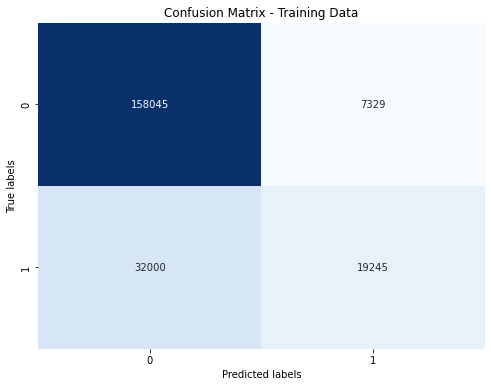

In [174]:
y_pred_test = lr_w2v.predict(X_test_w2v_pad)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix - Training Data")
plt.show()

While word embedding primarily focuses on the semantic meaning of words, we might assume it's the ideal choice for sentiment classification models. However, as demonstrated by the confusion matrix above, the impressive metric scores are largely due to the vast majority of tweets being classified as negative. This imbalance in the dataset, with significantly more negative tweets, skews the evaluation metrics.